In [1]:
# ✅ to remove, just for testing models
import math
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor, XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pickle

import numpy as np
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import get_scorer, make_scorer
from interpret.glassbox import ExplainableBoostingRegressor
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

In [2]:
df_preprocessed = pd.read_csv(r"data_preprocessed\with_outliers.csv")

In [3]:
#df_preprocessed = pd.read_csv(r"data_preprocessed\without_categorical.csv")

# Models

In [4]:
## Train / test split 
y = df_preprocessed.pop('average_rating')

X_train, X_test, y_train, y_test = train_test_split(df_preprocessed, y, test_size=0.3, random_state=42)

In [5]:
## Result Tab
global_result = pd.DataFrame(columns=['model name','RMSE','mae','r2_score'])

## Baseline

In [6]:
print('Test set size:', len(y_test))

Test set size: 3339


In [7]:
mean_ratings = y_test.mean().round(2)
y_pred = np.full((len(y_test)), mean_ratings)
y_pred

array([3.93, 3.93, 3.93, ..., 3.93, 3.93, 3.93])

### Metrics

In [8]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)

print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Baseline','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(5))

RMSE : 0.37753428370132325
mae : 0.23831686133572927
r2_score : -0.0
   Actual  Predicted
0    3.67       3.93
1    4.17       3.93
2    3.63       3.93
3    3.89       3.93
4    3.70       3.93


## Linear Regression

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
y_pred = lr.predict(X_test)

### Metrics

In [11]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print('Results of Linear Regression \n')
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'MAE : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2} \n')

# Create dictionnary to aggregte all result 

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Linear regression','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())


pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
print(pred.head(10))



Results of Linear Regression 

RMSE : 0.3679884151401649
MAE : 0.2264165511042027
r2_score : 0.05 

   Actual  Predicted
0    3.67   3.855962
1    4.17   3.844802
2    3.63   3.828242
3    3.89   3.852458
4    3.70   3.850240
5    4.14   3.819185
6    3.90   4.015663
7    4.75   3.948244
8    4.04   4.039631
9    3.46   3.978376


##  Random forest

In [12]:
parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [7, 10, 12, 15],
    'min_samples_split': [2,5],
    'min_samples_leaf': [5, 10, 15]
}
regr = RandomForestRegressor(random_state=0)

In [13]:
clf = GridSearchCV(estimator = regr, param_grid = parameters,cv=3,verbose=2, n_jobs = -1)

In [14]:
clf.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 12, 15],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [15]:
clf.best_params_

{'max_depth': 15,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

In [16]:
best_rf = clf.best_estimator_
y_pred = clf.predict(X_test)

In [17]:
importance_feature = pd.DataFrame(best_rf.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
importance_feature.sort_values(by=['Importance'],ascending=True,inplace=True)

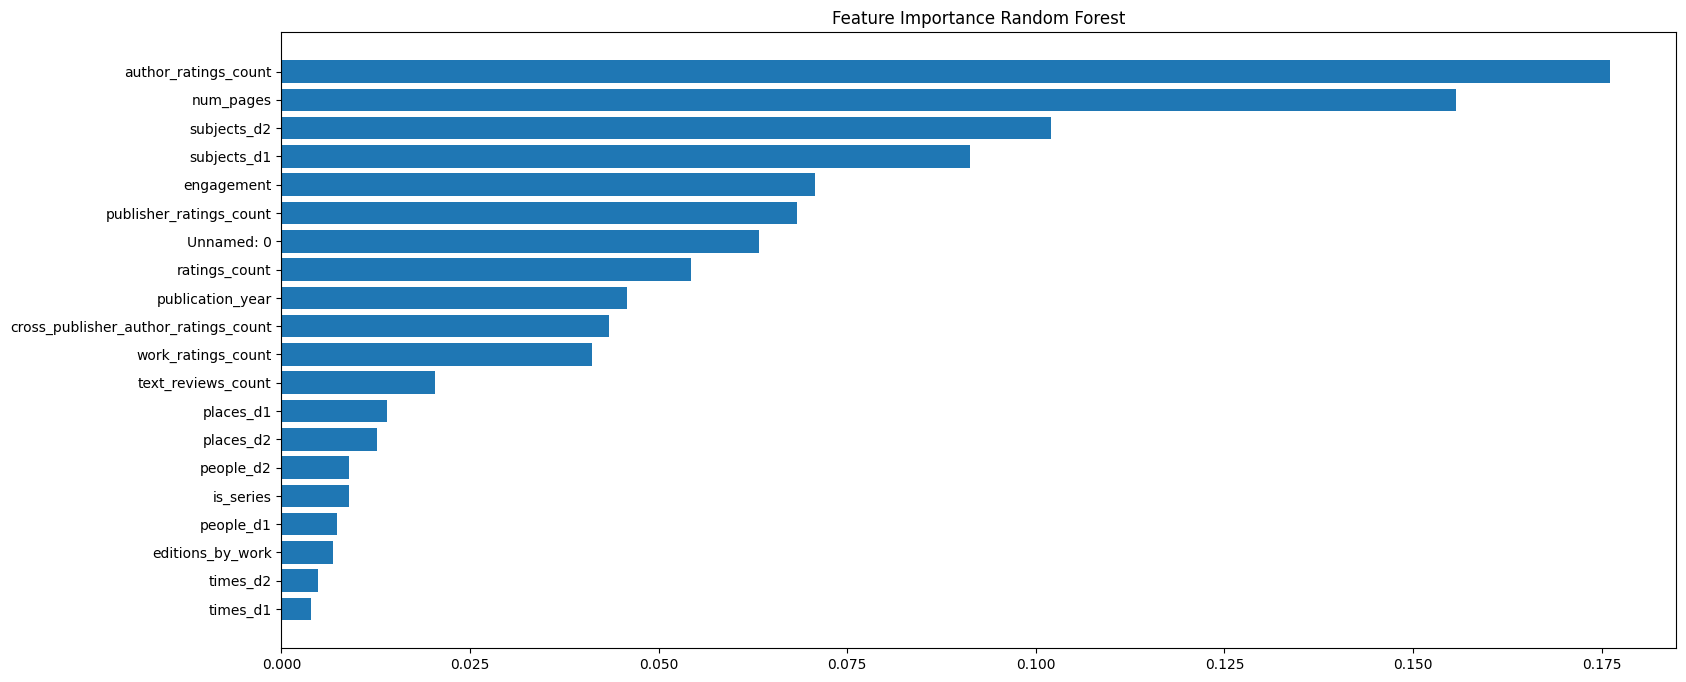

In [18]:
plt.figure(figsize=(18,8))
plt.barh(y=importance_feature.index,width=importance_feature.values.reshape((-1,)))
plt.title("Feature Importance Random Forest")
plt.show()

### Metrics

In [19]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print('Results of Random Forest after Grid Search \n')
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'MAE : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'R2_score : {r2.round(2)} \n')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'Random Forest','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)
pred.head(5)

Results of Random Forest after Grid Search 

RMSE : 0.31994784010932215
MAE : 0.20257752863628842
R2_score : 0.28 



,Actual,Predicted
0,3.67,3.838444
1,4.17,3.781753
2,3.63,3.792799
3,3.89,3.745708
4,3.70,3.908162


## XGBoost

In [20]:
xgb = XGBRegressor()

In [21]:
parameters = {'nthread':[6],
              'objective':['reg:linear'],
              'learning_rate': [0.01,.03], #so called `eta` value
              'max_depth': [5,7,15],
              'subsample': [0.5],
              'n_estimators': [500,1000]}

In [22]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [23]:
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[20:34:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.03], 'max_depth': [5, 7, 15],
                         'n_estimators': [500, 1000], 'nthread': [6],
                         'objective': ['reg:linear'], 'subsample': [0.5]},
             verbose=True)

In [24]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.2057412939435898
{'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000, 'nthread': 6, 'objective': 'reg:linear', 'subsample': 0.5}


In [25]:
optimal_xgb = xgb_grid.best_estimator_

In [26]:
y_pred = optimal_xgb.predict(X_test)

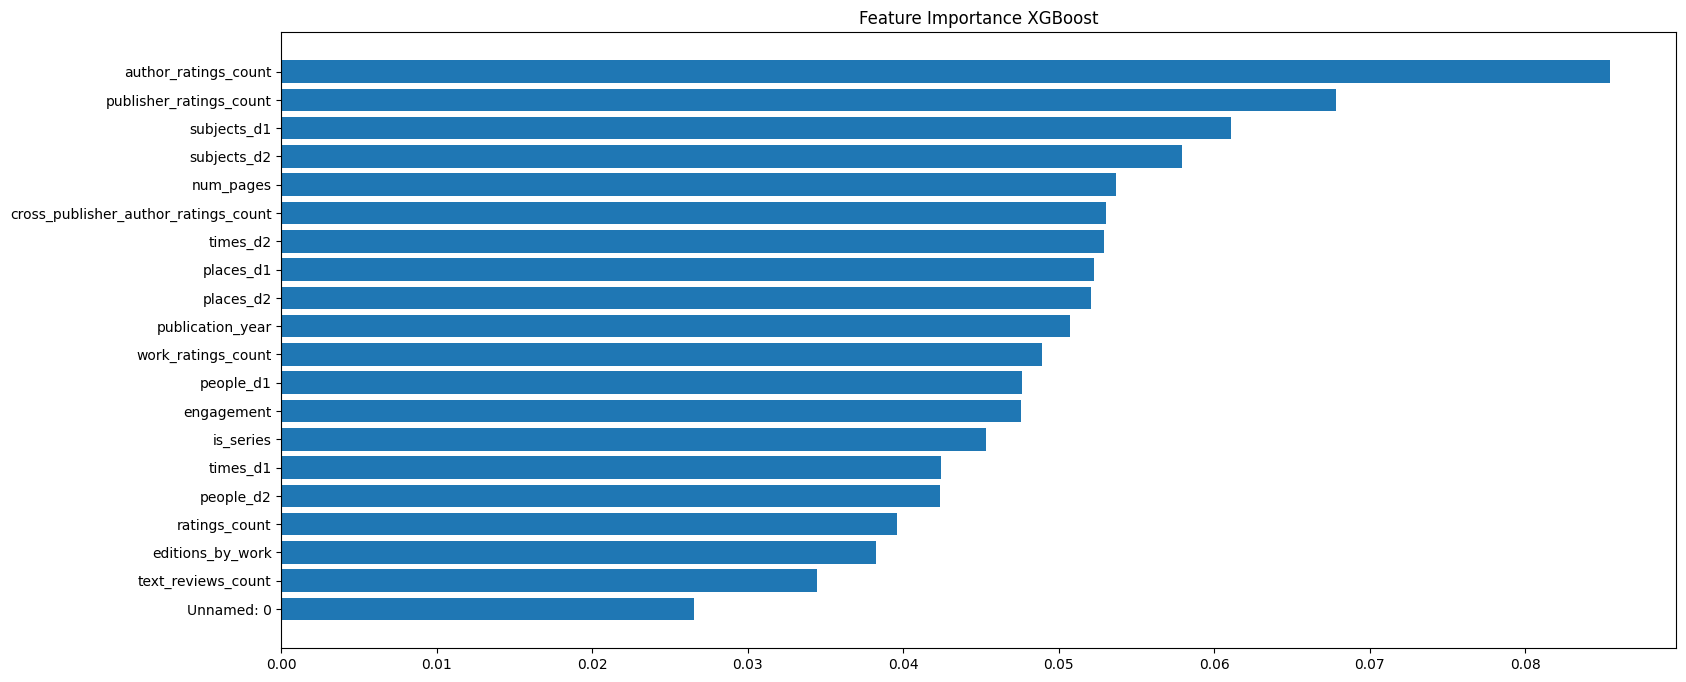

In [27]:
importance_feature = pd.DataFrame(optimal_xgb.feature_importances_,index=X_train.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
importance_feature.sort_values(by=['Importance'],ascending=True,inplace=True)

plt.figure(figsize=(18,8))
plt.barh(y=importance_feature.index,width=importance_feature.values.reshape((-1,)))
plt.title("Feature Importance XGBoost")
plt.show()

### Metrics

In [28]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print('Results of XGBoost after Grid Search \n')
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'MAE : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'R2_score : {r2.round(2)} \n')

# Create dictionnary to aggregte all result 
dict = {'model name' : 'XGBoost','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).head(25)

Results of XGBoost after Grid Search 

RMSE : 0.31564810578905705
MAE : 0.19421247047876733
R2_score : 0.3 



# Results

In [29]:
global_result

,model name,RMSE,mae,r2_score
0,Baseline,0.377534,0.238317,-0.0
1,Linear regression,0.367988,0.226417,0.05
2,Random Forest,0.319948,0.202578,0.28
3,XGBoost,0.315648,0.194212,0.3


In [30]:
pickle.dump(optimal_xgb, open("model/xgb_model.pkl", 'wb'))

# Cross Validation

In [ ]:
#script for cross validation

#function to preview the results
def preview_metrics(YTrue, YPred):
        
        MAE = mean_absolute_error(YTrue, YPred)
        MSE = mean_squared_error(YTrue, YPred)
        R2 = r2_score(YTrue, YPred)
               
        print("MAE", MAE.round(4))
        print("RMSE", np.sqrt(MSE).round(4))
        print("R2:",R2.round(2))


models = [
     
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    XGBRegressor(),
    AdaBoostRegressor(),
    ExplainableBoostingRegressor(),
    MLPRegressor(),
    #GaussianProcessRegressor()
]

models_names = [ 
    
       
    'Linear Regression',
    'Decision Tree',
    'Random Forest',
    'XGB',
    'Ada Boost',
    'Explainable Boosting', 
    'MLP',
    #'GaussianProcessRegressor'
        
]



for model, name in zip(models, models_names):
        
    #fit model
    #model.fit(X_train,y_train)
    
    scoring = ['r2','neg_mean_absolute_error','neg_root_mean_squared_error']
    scores = cross_validate(model, X_train,y_train, cv=10, scoring=scoring, return_estimator=True)
    #print("HERE ScorEs",scores['test_neg_root_mean_squared_error'])    
    INDEX = np.argmax(scores['test_r2'])    
    #print('INDEX', INDEX)    
    bestModel = scores['estimator'][INDEX]
    pred_y_test = bestModel.predict(X_test)
    pred_y_train = bestModel.predict(X_train)
       
    print("\n***************************")
    print("*****", name ,'******')
    print("***************************")
    #print("\n******", "Training Results" ,'******\n')
    #preview_metrics(y_train, pred_y_train)  
    print("******", "Testing Results" ,'******\n')
    preview_metrics(y_test, pred_y_test)




***************************
***** Linear Regression ******
***************************
****** Testing Results ******

MAE 0.2262
RMSE 0.3677
R2: 0.05

***************************
***** Decision Tree ******
***************************
****** Testing Results ******

MAE 0.2807
RMSE 0.4363
R2: -0.34
